# ICR - Identifying Age-Related Conditions Dataset with TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the ICR - Identifying Age-Related Conditions dataset made available for this competition. The goal of the model is to predict if a person has one or more of any of three medical conditions or none.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

# Import the libraries

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# from sklearn.model_selection import KFold
from sklearn.model_selection import(
    KFold,
    GroupKFold,
    train_test_split,
    TimeSeriesSplit,
    StratifiedKFold,
    StratifiedGroupKFold,
)

#Support Vector Machine components template
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, NuSVC
from sklearn.metrics import confusion_matrix, accuracy_score 

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.12.0
TensorFlow Decision Forests v1.3.0


# Load the Dataset

In [3]:
# dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
# print("Full train dataset shape is {}".format(dataset_df.shape))

In [4]:
dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
# test_ds_pd = test_df

#Get one hot program for column EJ
column_EJ = pd.get_dummies(dataset_df.EJ,dtype = "float64")

# The the length of the test data set.
column_length = len(column_EJ) 

#drop unwant column EJ after one hot coding
dataset_df = dataset_df.drop("EJ",axis = 1)
dataset_df = dataset_df.join(column_EJ)

# if the original EJ only have column A, inject a dummy B
if "B" not in column_EJ.columns :
#     dataset_df = dataset_df.join(column_EJ)
    #Creat a Dummy column for the integrity of the dataset.
    B_column = np.zeros(column_length).astype(float).tolist()
    dataset_df['B'] = B_column

# if the original EJ only have column A, inject a dummy B
elif "A" not in column_EJ.columns :
#     dataset_df = dataset_df.join(column_EJ)
    A_column = np.zeros(column_length).astype(float).tolist()
    dataset_df['A'] = A_column
dataset_df






,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FS,GB,GE,GF,GH,GI,GL,Class,A,B
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0.0,1.0
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1.0,0.0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,0.0,1.0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,0.0,1.0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0,1.0,0.0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0,0.0,1.0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0,1.0,0.0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0,0.0,1.0


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [5]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 59 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

In [6]:
dataset_df = dataset_df.fillna(0)

dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 59 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      617 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      617 non-null    float64
 17  CC      617 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

# Quick basic dataset exploration

In [7]:
dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FS,GB,GE,GF,GH,GI,GL,Class,A,B
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,0.420135,20.724856,131.714987,14679.595398,31.489716,50.584437,8.517134,0.175041,0.359806,0.640194
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,1.303465,9.991907,144.181524,19352.959387,9.864239,36.266251,10.324338,0.380310,0.480333,0.480333
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.000000,4.102182,72.611063,13.038894,9.432735,0.897628,0.000000,0.000000,0.000000,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124326,0.000000,0.000000,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.336226,0.000000,0.000000,1.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000,1.000000,1.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000,1.000000,1.000000


## Pie chart for label column: Class

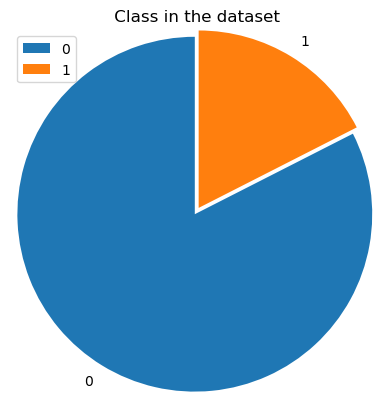

In [8]:
# plot_df = dataset_df.Class.value_counts()
# plot_df.plot(kind="pie")

class_vals = dataset_df.Class.value_counts()

plt.pie(
    class_vals,
    labels = class_vals.index,
    startangle = 90,
    explode = (0, 0.05),
    radius = 1.2
)

plt.title(' Class in the dataset')


plt.legend()
  
plt.show()

**Important**: From the pie chart we can see that the dataset is heavily imbalanced since the fraction of positive(`1`) samples is very small compared to the negative(`0`) samples.

# Numerical data distribution

First, we will list all the numerical columns names.

In [9]:
# Store all the numerical column names into a list
FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id", "EJ", "Class"]]

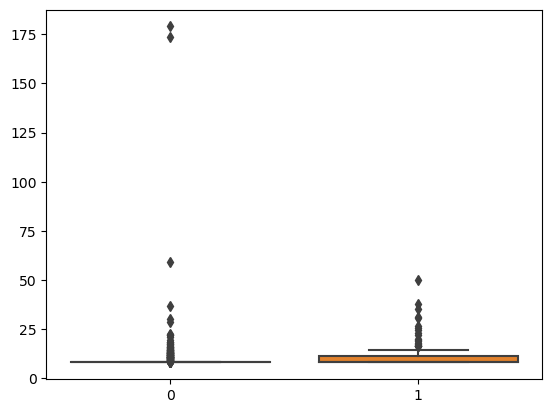

In [10]:
data_1 = dataset_df.query('Class == 0') # feature date in negetive class

data_2 = dataset_df.query('Class == 1') # feature data in positive class

data_1.describe()

data = [data_1.AR,data_2.AR] # In feature AR column, the positive class and the negative class

sns.boxplot(data) # Box plot for the negative and positive data,it is very clear how the data distribute in two class

plt.show()

Let us now plot the first 6 numerical columns and their values using bar charts.

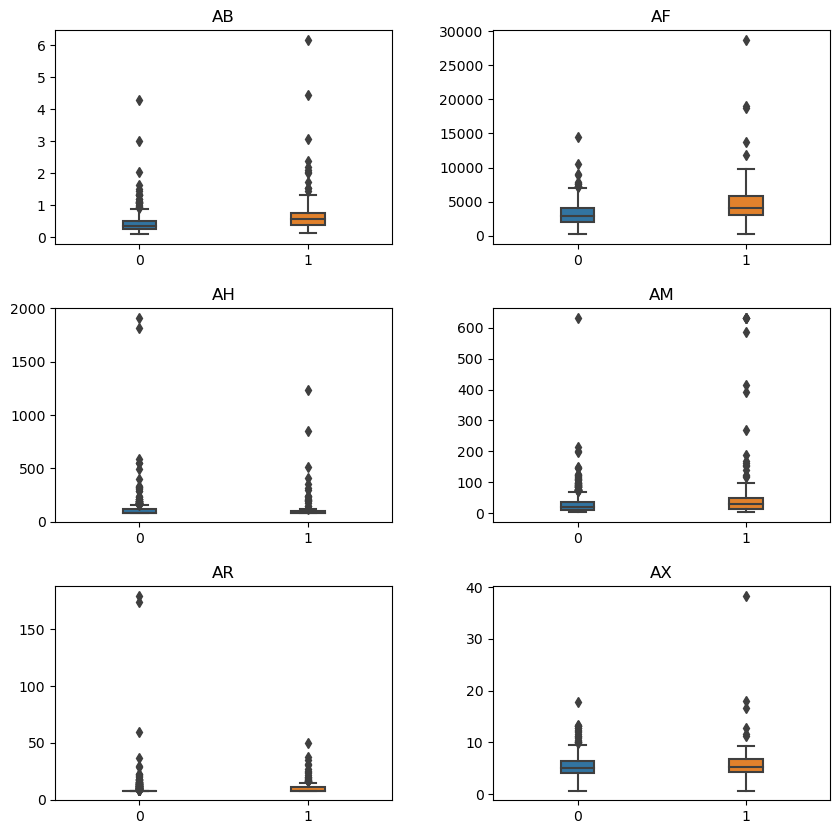

In [11]:
# figure, axis = plt.subplots(3, 2, figsize=(15, 15))
# plt.subplots_adjust(hspace=0.25, wspace=0.3)

# for i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):
#     row = i//2
#     col = i % 2
#     bp = sns.barplot(ax=axis[row, col], x=dataset_df['Id'], y=dataset_df[column_name])
#     bp.set(xticklabels=[])
#     #bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
#     axis[row, col].set_title(column_name)
# plt.show()

figure,axis = plt.subplots(3, 2, figsize = (10,10))
#Plot 3 row and 2 columns chart of the features

plt.subplots_adjust(hspace = 0.30, wspace = 0.30)
#Space in between each charts

for i, column_name in enumerate(FEATURE_COLUMNS[:6]):
    row = i // 2
    col = i % 2
    
    data = [data_1[column_name], data_2[column_name]]
    bp = sns.boxplot(ax=axis[row,col],data = data,width=0.2)
    axis[row, col].set_title(column_name)

plt.show()
   

We will also create a list of feature columns that will be used for training. We will drop `Id` from the list since it is not needed.

In [12]:
FEATURE_COLUMNS = [i for i in dataset_df.columns if i not in ["Id"]]

Now let us split the dataset into training and testing datasets:

# KFold validation

We will use KFold cross validation for training this model since the normal train/test split training won't be enough to acheive decent score.

We will split the dataset into 5 consecutive folds. Each fold is then used once as a validation set while the 4 (5-1) remaining folds form the training set.

Read more about KFold [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

In [13]:
# Creates a GroupKFold with 5 splits
kf = KFold(n_splits=5)

# Out of Fold (OOF)

During KFold cross validation, the predictions made on the test set of each fold is known as Out of Fold(OOF) predictions. We will estimate the performance of the model using the predictions made across all the k (5 in this example) folds.

For our training loop, we will create a pandas dataframe named `oof` to store the predictions of the validation set during each fold.

In [14]:
# Create list of ids for the creation of oof dataframe.
ID_LIST = dataset_df.index

# Create a dataframe of required size with zero values.
oof = pd.DataFrame(data=np.zeros((len(ID_LIST),1)), index=ID_LIST)

# Create an empty dictionary to store the models trained for each fold.
models = {}

# Create empty dict to save metircs for the models trained for each fold.
accuracy = {}
cross_entropy = {}

# Save the name of the label column to a variable.
label = "Class"

# Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [15]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

# How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get a better score.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1")```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

# Hyperparameter tuning to avoid overfitting

Because of the smaller size of the dataset, it is likely that the model will overfit during training.
Numerous parameters, primarily `max_depth` and `num_trees` can be changed to fine-tune the model and prevent overfitting.

The attribute`max_depth` indicates the maximum depth of the tree. To avoid overfitting, we can try to reduce the depth of the tree from it's default value, which is `16`. Another way to tackle overfitting is to increase the number of individual decision trees. To do this, we have to increase the value of the parameter `num_trees` from its default value(`300`).

You can set these parameters as follows:

```rf = tfdf.keras.RandomForestModel(max_depth=5, num_trees=500)```

# Strategies to handle the dataset imbalance

Let's examine the fraction of positive and negative samples in this dataset's  by examining the`Class` column.

In [16]:
# Calculate the number of negative and positive values in `Class` column
neg, pos = np.bincount(dataset_df['Class'])
# Calculate total samples
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 617
    Positive: 108 (17.50% of total)



As we can see, positive samples only account for 17.50% of the data. This means that our datastet is heavily imbalanced.

In classification problems with imbalanced datasets, a model tends to be more biased towards the majority class leading to the model performing poorly on the samples belonging to the minority class.

There are many techniques for dealing with imbalanced data. The most suitable techniques for this dataset are:

* Undersampling
* Class weighting

In this notebook we will use **Class weighting** to deal with imbalanced data. But first, we will quickly outline how undersampling can be performed.

# Undersampling

One approach to deal with an imbalanced dataset would be to under-sample the majority class(es) by choosing a smaller subset of the majority class samples(negative or `0` class in this case) from the dataset rather than picking the entire data.

Note: You have to loop through the dataset and try different random subsets for a better score.

The code snippet below illustrates how to perform undersampling.

```
# This function generates undersampled dataset.
def random_under_sampler(df):
    # Calculate the number of samples for each label. 
    neg, pos = np.bincount(df['Class'])

    # Choose the samples with class label `1`.
    one_df = df.loc[df['Class'] == 1] 
    # Choose the samples with class label `0`.
    zero_df = df.loc[df['Class'] == 0]
    # Select `pos` number of negative samples.
    # This makes sure that we have equal number of samples for each label.
    zero_df = zero_df.sample(n=pos)

    # Join both label dataframes.
    undersampled_df = pd.concat([zero_df, one_df])

    # Shuffle the data and return
    return undersampled_df.sample(frac = 1)
```

# Class weighting

Since the postive(`1`) `Class` labels are only a small fraction of the dataset, we would want the classifier to heavily weight those examples. You can do this by passing **Keras weights** for each class through a parameter. This will cause the model to "pay more attention" to examples from an under-represented class. Read more about class weights [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights).

In [17]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(dataset_df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


To train and evaluate the models using class weights, use the dict in model.fit() as an argument as shown below.

```model.fit(x=train_ds, class_weight=class_weight)```

# Train Random Forest Model

Today, we will use the defaults to create the Random Forest Model. By default the model is set to train for a classification task.
We will train a model for each fold and after training we will store the model and metrics. Here, we have chosen `accuracy` and `binary_crossentropy` as the metrics.

In [18]:
# Loop through each fold
label = "Class"
rf = tfdf.keras.RandomForestModel()
# rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1",max_depth=5, num_trees=500)
for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df)):
# for i, (train_index, valid_index) in enumerate(sgk.split(X= X_g, y = Y_g, groups = Combined_Group)):
        print('##### Fold',i+1)

        # Fetch values corresponding to the index 
        train_df = dataset_df.iloc[train_index]
        valid_df = dataset_df.iloc[valid_index]
        valid_ids = valid_df.index.values
        
        # Select only feature columns for training.
        train_df = train_df[FEATURE_COLUMNS]
        valid_df = valid_df[FEATURE_COLUMNS]
        
        # There's one more step required before we can train the model. 
        # We need to convert the datatset from Pandas format (pd.DataFrame)
        # into TensorFlow Datasets format (tf.data.Dataset).
        # TensorFlow Datasets is a high performance data loading library 
        # which is helpful when training neural networks with accelerators like GPUs and TPUs.
        # Note: Some column names contains white spaces at the end of their name, 
        # which is non-comaptible with SavedModels save format. 
        # By default, `pd_dataframe_to_tf_dataset` function will convert 
        # this column names into a compatible format. 
        # So you can safely ignore the warnings related to this.
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

        # Define the model and metrics
#         rf = tfdf.keras.RandomForestModel()
        rf.compile(metrics=["accuracy", "binary_crossentropy"]) 
        
        # Train the model
        # We will train the model using a one-liner.
        # Note: you may see a warning about Autograph. 
        # You can safely ignore this, it will be fixed in the next release.
        # Previously calculated class weights is used to handle imbalance.
#         rf.fit(x=train_ds, class_weight=class_weight)
        
#         # Store the model
#         models[f"fold_{i+1}"] = rf
        '''Testing function, shall be deleted if doesn't work '''
        
        if(i == 0):
            rf.fit(x=train_ds, class_weight=class_weight)
            models[f"fold_{i+1}"] = rf
        elif(i > 0 ):
            models[f"fold_{i}"].fit(x=train_ds, class_weight=class_weight)
            models[f"fold_{i+1}"] = models[f"fold_{i}"]
        
        # Predict OOF value for validation data
        predict = rf.predict(x=valid_ds)
        
        # Store the predictions in oof dataframe
        oof.loc[valid_ids, 0] = predict.flatten() 
        
        # Evaluate and store the metrics in respective dicts
        evaluation = rf.evaluate(x=valid_ds,return_dict=True)
        accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
        cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

Use /tmp/tmp73z62ev4 as temporary training directory
##### Fold 1
Reading training dataset...
Training dataset read in 0:00:08.386092. Found 493 examples.
Training model...
Model trained in 0:00:00.324770
Compiling model...


[INFO 23-08-14 09:34:48.5210 UTC kernel.cc:1242] Loading model from path /tmp/tmp73z62ev4/model/ with prefix bce868702ec34c96
[INFO 23-08-14 09:34:48.5822 UTC decision_forest.cc:660] Model loaded with 300 root(s), 14132 node(s), and 57 input feature(s).
[INFO 23-08-14 09:34:48.5824 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-14 09:34:48.5826 UTC kernel.cc:1074] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.
1/1 [==============================] - 1s 812ms/step - loss: 0.0000e+00 - accuracy: 0.9516 - binary_crossentropy: 0.2105
##### Fold 2
Reading training dataset...
Training dataset read in 0:00:00.214039. Found 493 examples.
Training model...
Model trained in 0:00:00.274410
Compiling model...


[INFO 23-08-14 09:34:53.4798 UTC kernel.cc:1242] Loading model from path /tmp/tmp73z62ev4/model/ with prefix bce868702ec34c96
[INFO 23-08-14 09:34:53.5380 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13408 node(s), and 57 input feature(s).
[INFO 23-08-14 09:34:53.5384 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 408ms/step - loss: 0.0000e+00 - accuracy: 0.8790 - binary_crossentropy: 0.2651
##### Fold 3
Reading training dataset...
Training dataset read in 0:00:00.192956. Found 494 examples.
Training model...
Model trained in 0:00:00.262112
Compiling model...


[INFO 23-08-14 09:34:55.1281 UTC kernel.cc:1242] Loading model from path /tmp/tmp73z62ev4/model/ with prefix bce868702ec34c96
[INFO 23-08-14 09:34:55.1835 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13228 node(s), and 57 input feature(s).
[INFO 23-08-14 09:34:55.1835 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 396ms/step - loss: 0.0000e+00 - accuracy: 0.9187 - binary_crossentropy: 0.2716
##### Fold 4
Reading training dataset...
Training dataset read in 0:00:00.203580. Found 494 examples.
Training model...
Model trained in 0:00:00.270019
Compiling model...


[INFO 23-08-14 09:34:56.7542 UTC kernel.cc:1242] Loading model from path /tmp/tmp73z62ev4/model/ with prefix bce868702ec34c96
[INFO 23-08-14 09:34:56.8123 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13454 node(s), and 57 input feature(s).
[INFO 23-08-14 09:34:56.8124 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 395ms/step - loss: 0.0000e+00 - accuracy: 0.9268 - binary_crossentropy: 0.2691
##### Fold 5
Reading training dataset...
Training dataset read in 0:00:00.206936. Found 494 examples.
Training model...
Model trained in 0:00:00.270347
Compiling model...


[INFO 23-08-14 09:34:58.9416 UTC kernel.cc:1242] Loading model from path /tmp/tmp73z62ev4/model/ with prefix bce868702ec34c96
[INFO 23-08-14 09:34:59.0007 UTC decision_forest.cc:660] Model loaded with 300 root(s), 13916 node(s), and 57 input feature(s).
[INFO 23-08-14 09:34:59.0008 UTC abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 23-08-14 09:34:59.0008 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 396ms/step - loss: 0.0000e+00 - accuracy: 0.9512 - binary_crossentropy: 0.2225


# Visualize the model
One benefit of tree-based models is that we can easily visualize them. The default number of trees used in the Random Forests is 300. We can select any tree for display.

Let us pick one model from the `models` dict and select a tree for display.

In [19]:
tfdf.model_plotter.plot_model_in_colab(models['fold_1'], tree_idx=0, max_depth=3)

# Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training, we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model. The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the `binary_crossentropy` evaluated on the out of bag dataset according to the number of trees in the model. Let us plot this for the models of each fold.

Note: Smaller values are better for this hyperparameter.

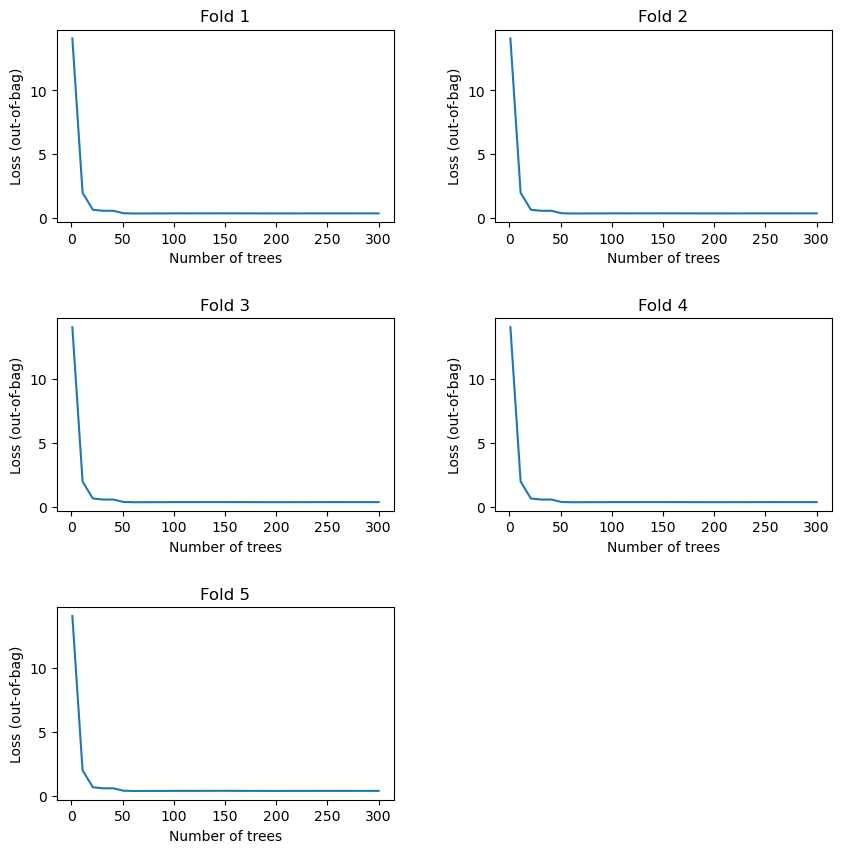

In [20]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

axis[2][1].set_visible(False)
plt.show()

We can also see some general stats on the OOB dataset:

In [21]:
for _model in models:
    inspector = models[_model].make_inspector()
    print(_model, inspector.evaluation())

fold_1 Evaluation(num_examples=494, accuracy=0.8683688603016692, loss=0.3770846636024589, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_2 Evaluation(num_examples=494, accuracy=0.8683688603016692, loss=0.3770846636024589, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_3 Evaluation(num_examples=494, accuracy=0.8683688603016692, loss=0.3770846636024589, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_4 Evaluation(num_examples=494, accuracy=0.8683688603016692, loss=0.3770846636024589, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_5 Evaluation(num_examples=494, accuracy=0.8683688603016692, loss=0.3770846636024589, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)


Now, let us check the evaluation metrics for each fold and its average value.

In [22]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print(f"\nAverage accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")

fold_1: acc: 0.9516 loss: 0.2105
fold_2: acc: 0.8790 loss: 0.2651
fold_3: acc: 0.9187 loss: 0.2716
fold_4: acc: 0.9268 loss: 0.2691
fold_5: acc: 0.9512 loss: 0.2225

Average accuracy: 0.9255  Average loss: 0.2478


# Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests. Let us pick one model from models dict and inspect it.

Let us list the available `Variable Importances` for Decision Trees:

In [23]:
inspector = models['fold_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES
	 NUM_AS_ROOT


As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [24]:
# Each line is: (feature name, (index of the feature), importance score)
inspector.variable_importances()["NUM_AS_ROOT"]

[("DU" (1; #34), 41.0),
 ("FL" (1; #48), 35.0),
 ("BQ" (1; #14), 27.0),
 ("GL" (1; #56), 26.0),
 ("AF" (1; #2), 21.0),
 ("AB" (1; #1), 19.0),
 ("CR" (1; #23), 19.0),
 ("DA" (1; #27), 12.0),
 ("EH" (1; #40), 12.0),
 ("FI" (1; #47), 12.0),
 ("BC" (1; #10), 11.0),
 ("DI" (1; #31), 11.0),
 ("DE" (1; #28), 8.0),
 ("FD_" (1; #45), 8.0),
 ("FE" (1; #46), 8.0),
 ("BN" (1; #12), 4.0),
 ("CC" (1; #18), 4.0),
 ("DF" (1; #29), 3.0),
 ("EB" (1; #37), 3.0),
 ("GF" (1; #53), 3.0),
 ("CU" (1; #25), 2.0),
 ("DL" (1; #32), 2.0),
 ("DY" (1; #36), 2.0),
 ("EE" (1; #38), 2.0),
 ("AM" (1; #4), 1.0),
 ("AR" (1; #5), 1.0),
 ("BR" (1; #15), 1.0),
 ("DH" (1; #30), 1.0),
 ("FR" (1; #49), 1.0)]

# StratifiedGroupFold()

## Re oraganize groups 

Regroup the data from greeks.csv

In [25]:
# grouped the datas for future analysis and training with cross validation

# X_g = df_merged[Feature_Columns] # the features collection

# Y_g = df_merged[["Class"]] # The target collection
greeks_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")

Groups = greeks_df[["Alpha","Beta","Gamma","Delta"]] # the groups collection
Groups.columns[Groups.isna().any()]
Combined_Group = Groups["Alpha"].astype(str) +  Groups["Beta"] + Groups["Gamma"] + Groups["Delta"]
Combined_Group

0      BCGD
1      ACMB
2      ACMB
3      ACMB
4      DBFB
       ... 
612    ABMB
613    ABMB
614    ACMB
615    ACMB
616    ACMB
Length: 617, dtype: object

## Stratified Group Fold module


In [26]:
sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=529)

In [27]:

Features = [x for x in FEATURE_COLUMNS if x not in ["Class"] ]
Features
X_g = dataset_df[Features]
Y_g = dataset_df["Class"]
# X_g = dataset_df[[Features]]



In [28]:
   tuner = tfdf.tuner.RandomSearch(
        # 200 trials to find the best hyper-parameters.
        num_trials=200,
        # Use the pre-defined hyper-parameter space.
        use_predefined_hps=True,
        # Each model is trained on 4 threads.
        trial_num_threads=4)

## Train Gradient Boosted Trees Model

In [29]:
# Loop through each fold
rf = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1",max_depth=5, num_trees=500, tuner = tuner)
label = "Class"
# rf = tfdf.keras.RandomForestModel()
# rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1",max_depth=5, num_trees=500)

for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df)):
# for i, (train_index, valid_index) in enumerate(sgk.split(X= X_g, y = Y_g, groups = Combined_Group)):


        print('##### Fold',i+1)

        # Fetch values corresponding to the index 
        train_df = dataset_df.iloc[train_index]
        valid_df = dataset_df.iloc[valid_index]
        valid_ids = valid_df.index.values
        
        # Select only feature columns for training.
        train_df = train_df[FEATURE_COLUMNS]
        valid_df = valid_df[FEATURE_COLUMNS]
        
        # There's one more step required before we can train the model. 
        # We need to convert the datatset from Pandas format (pd.DataFrame)
        # into TensorFlow Datasets format (tf.data.Dataset).
        # TensorFlow Datasets is a high performance data loading library 
        # which is helpful when training neural networks with accelerators like GPUs and TPUs.
        # Note: Some column names contains white spaces at the end of their name, 
        # which is non-comaptible with SavedModels save format. 
        # By default, `pd_dataframe_to_tf_dataset` function will convert 
        # this column names into a compatible format. 
        # So you can safely ignore the warnings related to this.
        train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
        valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)

        # Define the model and metrics
#         rf = tfdf.keras.RandomForestModel()
        rf.compile(metrics=["accuracy", "binary_crossentropy"]) 
        
        # Train the model
        # We will train the model using a one-liner.
        # Note: you may see a warning about Autograph. 
        # You can safely ignore this, it will be fixed in the next release.
        # Previously calculated class weights is used to handle imbalance.
#         rf.fit(x=train_ds, class_weight=class_weight)
        
#         # Store the model
#         models[f"fold_{i+1}"] = rf
        '''Testing function, shall be deleted if doesn't work '''
        
        if(i == 0):
            rf.fit(x=train_ds, class_weight=class_weight)
            models[f"fold_{i+1}"] = rf
        elif(i > 0 ):
            models[f"fold_{i}"].fit(x=train_ds, class_weight=class_weight)
            models[f"fold_{i+1}"] = models[f"fold_{i}"]        
        
        # Predict OOF value for validation data
        predict = rf.predict(x=valid_ds)
        
        # Store the predictions in oof dataframe
        oof.loc[valid_ids, 0] = predict.flatten() 
        
        # Evaluate and store the metrics in respective dicts
        evaluation = rf.evaluate(x=valid_ds,return_dict=True)
        accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
        cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]
        
        

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpapz7ohni as temporary training directory
##### Fold 1
Reading training dataset...


[WARNING 23-08-14 09:35:02.8716 UTC gradient_boosted_trees.cc:1797] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-14 09:35:02.8716 UTC gradient_boosted_trees.cc:1808] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 23-08-14 09:35:02.8716 UTC gradient_boosted_trees.cc:1822] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.163197. Found 493 examples.
Training model...
Model trained in 0:03:05.690961
Compiling model...


[INFO 23-08-14 09:38:09.8829 UTC kernel.cc:1242] Loading model from path /tmp/tmpapz7ohni/model/ with prefix ec28c937d48c4a41
[INFO 23-08-14 09:38:09.9197 UTC decision_forest.cc:660] Model loaded with 237 root(s), 4997 node(s), and 57 input feature(s).
[INFO 23-08-14 09:38:09.9198 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-08-14 09:38:09.9198 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 402ms/step - loss: 0.0000e+00 - accuracy: 0.9597 - binary_crossentropy: 0.1437
##### Fold 2
Reading training dataset...
Training dataset read in 0:00:00.191225. Found 493 examples.
Training model...
Model trained in 0:04:00.078998
Compiling model...


[INFO 23-08-14 09:42:27.0719 UTC kernel.cc:1242] Loading model from path /tmp/tmpapz7ohni/model/ with prefix ec28c937d48c4a41
[INFO 23-08-14 09:42:27.1235 UTC decision_forest.cc:660] Model loaded with 198 root(s), 8778 node(s), and 57 input feature(s).
[INFO 23-08-14 09:42:27.1251 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-08-14 09:42:27.1258 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 386ms/step - loss: 0.0000e+00 - accuracy: 0.8952 - binary_crossentropy: 0.2769
##### Fold 3
Reading training dataset...
Training dataset read in 0:00:00.195318. Found 494 examples.
Training model...
Model trained in 0:03:57.415873
Compiling model...


[INFO 23-08-14 09:46:25.8842 UTC kernel.cc:1242] Loading model from path /tmp/tmpapz7ohni/model/ with prefix ec28c937d48c4a41
[INFO 23-08-14 09:46:25.9076 UTC decision_forest.cc:660] Model loaded with 136 root(s), 3068 node(s), and 57 input feature(s).
[INFO 23-08-14 09:46:25.9078 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-08-14 09:46:25.9078 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 400ms/step - loss: 0.0000e+00 - accuracy: 0.9593 - binary_crossentropy: 0.2008
##### Fold 4
Reading training dataset...
Training dataset read in 0:00:00.214341. Found 494 examples.
Training model...
Model trained in 0:02:43.267478
Compiling model...


[INFO 23-08-14 09:49:10.5369 UTC kernel.cc:1242] Loading model from path /tmp/tmpapz7ohni/model/ with prefix ec28c937d48c4a41
[INFO 23-08-14 09:49:10.5502 UTC decision_forest.cc:660] Model loaded with 67 root(s), 1387 node(s), and 57 input feature(s).
[INFO 23-08-14 09:49:10.5503 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-08-14 09:49:10.5504 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 403ms/step - loss: 0.0000e+00 - accuracy: 0.9106 - binary_crossentropy: 0.2635
##### Fold 5
Reading training dataset...
Training dataset read in 0:00:00.201184. Found 494 examples.
Training model...
Model trained in 0:02:31.504580
Compiling model...


[INFO 23-08-14 09:51:43.3928 UTC kernel.cc:1242] Loading model from path /tmp/tmpapz7ohni/model/ with prefix ec28c937d48c4a41
[INFO 23-08-14 09:51:43.4094 UTC decision_forest.cc:660] Model loaded with 288 root(s), 1956 node(s), and 57 input feature(s).
[INFO 23-08-14 09:51:43.4097 UTC abstract_model.cc:1311] Engine "GradientBoostedTreesGeneric" built
[INFO 23-08-14 09:51:43.4098 UTC kernel.cc:1074] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 401ms/step - loss: 0.0000e+00 - accuracy: 0.9350 - binary_crossentropy: 0.1746


## Visualize the model

In [30]:
tfdf.model_plotter.plot_model_in_colab(models['fold_1'], tree_idx=0, max_depth=3)

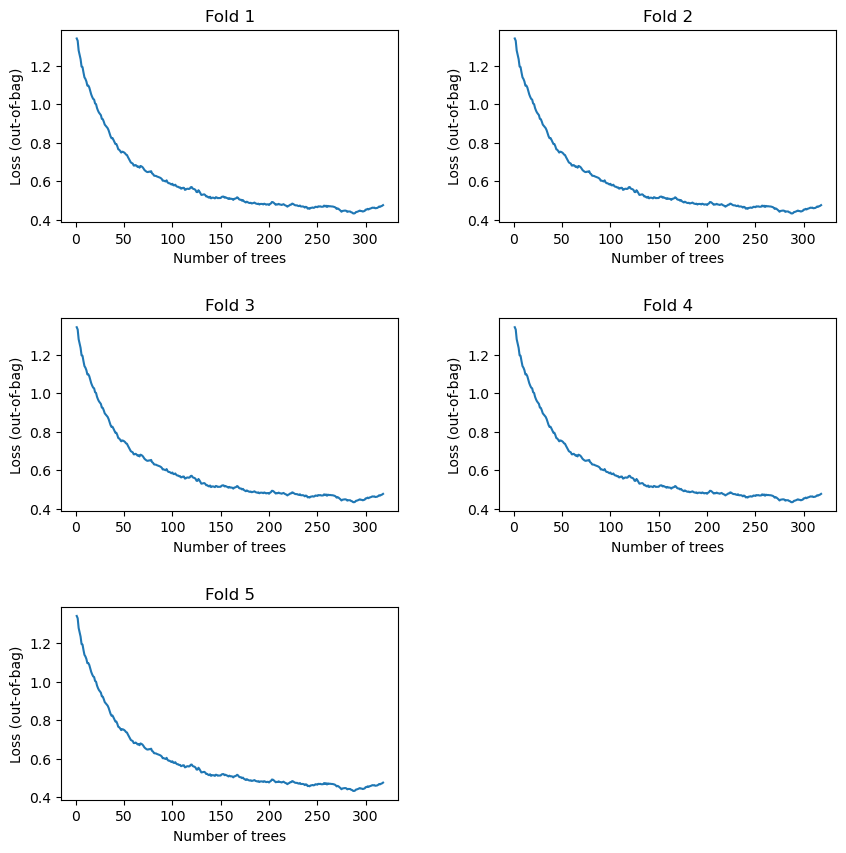

In [31]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for i, fold_no in enumerate(models.keys()):
    row = i//2
    col = i % 2
    logs = models[fold_no].make_inspector().training_logs()
    axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    axis[row, col].set_title(f"Fold {i+1}")
    axis[row, col].set_xlabel('Number of trees')
    axis[row, col].set_ylabel('Loss (out-of-bag)')

axis[2][1].set_visible(False)
plt.show()

In [32]:
for _model in models:
    inspector = models[_model].make_inspector()
    print(_model, inspector.evaluation())

fold_1 Evaluation(num_examples=None, accuracy=0.9369112253189087, loss=0.4329851269721985, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_2 Evaluation(num_examples=None, accuracy=0.9369112253189087, loss=0.4329851269721985, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_3 Evaluation(num_examples=None, accuracy=0.9369112253189087, loss=0.4329851269721985, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_4 Evaluation(num_examples=None, accuracy=0.9369112253189087, loss=0.4329851269721985, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)
fold_5 Evaluation(num_examples=None, accuracy=0.9369112253189087, loss=0.4329851269721985, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)


In [33]:
average_loss = 0
average_acc = 0

for _model in  models:
    average_loss += cross_entropy[_model]
    average_acc += accuracy[_model]
    print(f"{_model}: acc: {accuracy[_model]:.4f} loss: {cross_entropy[_model]:.4f}")

print(f"\nAverage accuracy: {average_acc/5:.4f}  Average loss: {average_loss/5:.4f}")

fold_1: acc: 0.9597 loss: 0.1437
fold_2: acc: 0.8952 loss: 0.2769
fold_3: acc: 0.9593 loss: 0.2008
fold_4: acc: 0.9106 loss: 0.2635
fold_5: acc: 0.9350 loss: 0.1746

Average accuracy: 0.9319  Average loss: 0.2119


# More train model

Hyparemeter tuning for GradientBoostedTrees Model

## Trying Support Vector Machine

In [34]:
# dataset_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
# # test_ds_pd = test_df

# #Get one hot program for column EJ
# column_EJ = pd.get_dummies(dataset_df.EJ,dtype = "float64")

# # The the length of the test data set.
# column_length = len(column_EJ) 

# #drop unwant column EJ after one hot coding
# dataset_df = dataset_df.drop("EJ",axis = 1)
# dataset_df = dataset_df.join(column_EJ)

# # if the original EJ only have column A, inject a dummy B
# if "B" not in column_EJ.columns :
# #     dataset_df = dataset_df.join(column_EJ)
#     #Creat a Dummy column for the integrity of the dataset.
#     B_column = np.zeros(column_length).astype(float).tolist()
#     dataset_df['B'] = B_column

# # if the original EJ only have column A, inject a dummy B
# elif "A" not in column_EJ.columns :
# #     dataset_df = dataset_df.join(column_EJ)
#     A_column = np.zeros(column_length).astype(float).tolist()
#     dataset_df['A'] = A_column
# dataset_df






In [35]:
# X_t, Y_g,x_h,y_h = (train_df[Features],train_df['Class'],
#                             valid_df[Features],valid_df['Class'])
# X_t = np.asanyarray(X_t)
# X_t

In [36]:
# log_reg = LogisticRegression()
# The recommended standarScaler and SVM piline

clf = make_pipeline(StandardScaler(), SVC(kernel = 'linear',gamma = 'auto'))


In [37]:
# # Loop through each fold
# label = "Class"
# # rf = tfdf.keras.RandomForestModel()
# # rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1",max_depth=5, num_trees=500)
# for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df)):
# # for i, (train_index, valid_index) in enumerate(sgk.split(X= X_g, y = Y_g, groups = Combined_Group)):
#         print('##### Fold',i+1)

#         # Fetch values corresponding to the index 
#         train_df = dataset_df.iloc[train_index]
#         valid_df = dataset_df.iloc[valid_index]
#         valid_ids = valid_df.index.values
        
#         # Select only feature columns for training.
#         train_df = train_df[FEATURE_COLUMNS]
#         valid_df = valid_df[FEATURE_COLUMNS]
        
# #         train_df.info()
#         # There's one more step required before we can train the model. 
#         # We need to convert the datatset from Pandas format (pd.DataFrame)
#         # into TensorFlow Datasets format (tf.data.Dataset).
#         # TensorFlow Datasets is a high performance data loading library 
#         # which is helpful when training neural networks with accelerators like GPUs and TPUs.
#         # Note: Some column names contains white spaces at the end of their name, 
#         # which is non-comaptible with SavedModels save format. 
#         # By default, `pd_dataframe_to_tf_dataset` function will convert 
#         # this column names into a compatible format. 
#         # So you can safely ignore the warnings related to this.
# #         '''Convert to tensor'''
# #         train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
# #         valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)
#         X_t, Y_t,x_h,y_h = (train_df[Features],train_df['Class'],
#                             valid_df[Features],valid_df['Class'])
#         X_t = np.asanyarray(X_t)
#         Y_t = np.asanyarray(Y_t)
#         x_h = np.asanyarray(x_h)
#         y_h = np.asanyarray(y_h)
        
     

#         # Define the model and metrics

# #         rf.compile(metrics=["accuracy", "binary_crossentropy"]) 
# #         SVC.compile(metrics=["accuracy", "binary_crossentropy"])
#         # Train the model
#         # We will train the model using a one-liner.
#         # Note: you may see a warning about Autograph. 
#         # You can safely ignore this, it will be fixed in the next release.
#         # Previously calculated class weights is used to handle imbalance.
# # #        rf.fit(x=train_ds, class_weight=class_weight)
#         clf.fit(X_t,Y_t)

#         # Store the model
# #         models[f"fold_{i+1}"] = rf
        
#         models[f"fold_{i+1}"] = clf
        
        
#         # Predict OOF value for validation data
# #         predict = rf.predict(x=valid_ds)
        
#         predict = clf.predict(X =x_h)
# #         predict = models["fold_3"].predict(X =x_h)
        
#         # Store the predictions in oof dataframe
#         oof.loc[valid_ids, 0] = predict.flatten() 
        
#         # Evaluate and store the metrics in respective dicts
# #         evaluation = rf.evaluate(x=valid_ds,return_dict=True)
#         score = clf.score(X=x_h,y = y_h)
#         print('modle score:',evaluation)
        
#         ''' The evaluation of the SVM '''
#         # Evaluating the accuracy of the model using the sklearn functions
#         accuracy = accuracy_score(y_h,predict)*100
#         confusion_mat = confusion_matrix(y_h,predict)
#         # Printing the results
#         print("Accuracy for SVM is:",accuracy)
#         print("Confusion Matrix")
#         print(confusion_mat)

# #         accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
# #         cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]

In [38]:
# figure, axis = plt.subplots(3, 2, figsize=(10, 10))
# plt.subplots_adjust(hspace=0.5, wspace=0.3)

# for i, fold_no in enumerate(models.keys()):
#     row = i//2
#     col = i % 2
#     logs = models[fold_no].make_inspector().training_logs()
#     axis[row, col].plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
#     axis[row, col].set_title(f"Fold {i+1}")
#     axis[row, col].set_xlabel('Number of trees')
#     axis[row, col].set_ylabel('Loss (out-of-bag)')

# axis[2][1].set_visible(False)
# plt.show()

In [39]:
# for _model in models:
#     inspector = models[_model].make_inspector()
#     print(_model, inspector.evaluation())
# # for _model in models:
# #     inspector = models[_model].make_inspector()
# #     print(_model, inspector.evaluation())

In [40]:

# Make the test data set match with the 
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

# test_ds_pd = test_df

#Get one hot program for column EJ
column_EJ = pd.get_dummies(test_df.EJ,dtype = "float64")
# The the length of the test data set.
column_length = len(column_EJ) 

#drop unwant column EJ after one hot coding
test_df = test_df.drop("EJ",axis = 1)
test_df = test_df.join(column_EJ)

# if the original EJ only have column A, inject a dummy B
if "B" not in column_EJ.columns :
#     test_df_new = test_df_new.join(column_EJ)
    #Creat a Dummy column for the integrity of the dataset.
    B_column = np.zeros(column_length).astype(float).tolist()
    test_df['B'] = B_column

# if the original EJ only have column A, inject a dummy B
elif "A" not in column_EJ.columns :
#     test_df_new = test_df_new.join(column_EJ)
    A_column = np.zeros(column_length).astype(float).tolist()
    test_df['A'] = A_column

test_df.info()
    
# # test_df_new = test_df_new.join(column_EJ)
# test_df_new
# B_column = [0.0,0.0,0.0,0.0,0.0]
# test_df_new['B'] = B_column


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5 non-null      object 
 1   AB      5 non-null      float64
 2   AF      5 non-null      float64
 3   AH      5 non-null      float64
 4   AM      5 non-null      float64
 5   AR      5 non-null      float64
 6   AX      5 non-null      float64
 7   AY      5 non-null      float64
 8   AZ      5 non-null      float64
 9   BC      5 non-null      float64
 10  BD      5 non-null      float64
 11  BN      5 non-null      float64
 12  BP      5 non-null      float64
 13  BQ      5 non-null      float64
 14  BR      5 non-null      float64
 15  BZ      5 non-null      float64
 16  CB      5 non-null      float64
 17  CC      5 non-null      float64
 18  CD      5 non-null      float64
 19  CF      5 non-null      float64
 20  CH      5 non-null      float64
 21  CL      5 non-null      float64
 22  CR    

In [41]:
# '''This section is used for the prediction for SVM model'''
# # test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
# test_ds_pd = test_df
# test_df_columns = test_ds_pd.columns.tolist()
# # TEST_FEATURE_COLUMNS = [i for i in FEATURE_COLUMNS \
# #                         if i in test_df_columns and i != "Class"]
# TEST_FEATURE_COLUMNS = [i for i in FEATURE_COLUMNS \
#                         if i in test_df_columns and i not in ["Class","ID"]]
# test_ds_pd = test_ds_pd[TEST_FEATURE_COLUMNS]
# # test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd) #for keras model
# test_ds_pd = np.asanyarray(test_ds_pd) # for SVM only
# predictions = models['fold_3'].predict(test_ds_pd)
# np.asanyarray(X_t)
# n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
# print(n_predictions)

# Submission

In [42]:
'''This section is used for the prediction for keras model'''
# test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')
test_ds_pd = test_df
test_df_columns = test_ds_pd.columns.tolist()
TEST_FEATURE_COLUMNS = [i for i in FEATURE_COLUMNS \
                        if i in test_df_columns and i != "Class"]
test_ds_pd = test_ds_pd[TEST_FEATURE_COLUMNS]
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd)
predictions = models['fold_5'].predict(test_ds)
n_predictions= [[round(abs(i-1), 8), i] for i in predictions.ravel()]
print(n_predictions)

1/1 [==============================] - 0s 156ms/step
[[0.84769093, 0.15230907], [0.84769093, 0.15230907], [0.84769093, 0.15230907], [0.84769093, 0.15230907], [0.84769093, 0.15230907]]


In [43]:
sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
sample_submission[['class_0', 'class_1']] = n_predictions
sample_submission.to_csv('/kaggle/working/submission.csv', index=False)

In [44]:
pd.read_csv('/kaggle/working/submission.csv')

,Id,class_0,class_1
0,00eed32682bb,0.847691,0.152309
1,010ebe33f668,0.847691,0.152309
2,02fa521e1838,0.847691,0.152309
3,040e15f562a2,0.847691,0.152309
4,046e85c7cc7f,0.847691,0.152309


In [45]:
# from sklearn.datasets import load_iris
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_graphviz
# from graphviz import Source

In [46]:
# tree_clf = DecisionTreeClassifier(criterion='entropy',
#                                   max_depth=2)

In [47]:
# # Loop through each fold
# label = "Class"
# # rf = tfdf.keras.RandomForestModel()
# # rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1",max_depth=5, num_trees=500)
# for i, (train_index, valid_index) in enumerate(kf.split(X=dataset_df)):
# # for i, (train_index, valid_index) in enumerate(sgk.split(X= X_g, y = Y_g, groups = Combined_Group)):
#         print('##### Fold',i+1)

#         # Fetch values corresponding to the index 
#         train_df = dataset_df.iloc[train_index]
#         valid_df = dataset_df.iloc[valid_index]
#         valid_ids = valid_df.index.values
        
#         # Select only feature columns for training.
#         train_df = train_df[FEATURE_COLUMNS]
#         valid_df = valid_df[FEATURE_COLUMNS]
        
# #         train_df.info()
#         # There's one more step required before we can train the model. 
#         # We need to convert the datatset from Pandas format (pd.DataFrame)
#         # into TensorFlow Datasets format (tf.data.Dataset).
#         # TensorFlow Datasets is a high performance data loading library 
#         # which is helpful when training neural networks with accelerators like GPUs and TPUs.
#         # Note: Some column names contains white spaces at the end of their name, 
#         # which is non-comaptible with SavedModels save format. 
#         # By default, `pd_dataframe_to_tf_dataset` function will convert 
#         # this column names into a compatible format. 
#         # So you can safely ignore the warnings related to this.
# #         '''Convert to tensor'''
# #         train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label)
# #         valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_df, label=label)
#         X_t, Y_t,x_h,y_h = (train_df[Features],train_df['Class'],
#                             valid_df[Features],valid_df['Class'])
#         X_t = np.asanyarray(X_t)
#         Y_t = np.asanyarray(Y_t)
#         x_h = np.asanyarray(x_h)
#         y_h = np.asanyarray(y_h)
        
     

#         # Define the model and metrics

# #         rf.compile(metrics=["accuracy", "binary_crossentropy"]) 
# #         SVC.compile(metrics=["accuracy", "binary_crossentropy"])
#         # Train the model
#         # We will train the model using a one-liner.
#         # Note: you may see a warning about Autograph. 
#         # You can safely ignore this, it will be fixed in the next release.
#         # Previously calculated class weights is used to handle imbalance.
# # #        rf.fit(x=train_ds, class_weight=class_weight)
#         if(i == 0):
#             tree_clf.fit(X_t,Y_t)
#             models[f"fold_{i+1}"] = tree_clf
#         elif(i > 0 ):
#             models[f"fold_{i}"].fit(X_t,Y_t)
#             models[f"fold_{i+1}"] = models[f"fold_{i}"]

#         # Store the model
# #         models[f"fold_{i+1}"] = rf
        
#         models[f"fold_{i+1}"] = tree_clf
        
        
#         # Predict OOF value for validation data
# #         predict = rf.predict(x=valid_ds)
        
#         predict = tree_clf.predict(X =x_h)
# #         predict = models["fold_3"].predict(X =x_h)
        
#         # Store the predictions in oof dataframe
#         oof.loc[valid_ids, 0] = predict.flatten() 
        
#         # Evaluate and store the metrics in respective dicts
# #         evaluation = rf.evaluate(x=valid_ds,return_dict=True)
# #         score = clf.score(X=x_h,y = y_h)
#         print('modle score:',evaluation)
        
#         ''' The evaluation of the SVM '''
#         # Evaluating the accuracy of the model using the sklearn functions
#         accuracy = accuracy_score(y_h,predict)*100
#         confusion_mat = confusion_matrix(y_h,predict)
#         # Printing the results
#         print("Accuracy for decision tree is:",accuracy)
#         print("Confusion Matrix")
#         print(confusion_mat)

# #         accuracy[f"fold_{i+1}"] = evaluation["accuracy"]
# #         cross_entropy[f"fold_{i+1}"]= evaluation["binary_crossentropy"]